In [152]:
import os
import pybullet_envs
import numpy as np
import matplotlib.pyplot as plt
# import panda_gym # Not in requirements, required for panda envs, get latest from here: https://github.com/qgallouedec/panda-gym , don't use version from pypy 

from seagul.zoo3_utils import load_zoo_agent, ALGOS
from seagul.mesh import dict_to_array

path_to_zoo = "/home/sgillen/work/external/rl-baselines3-zoo/" # Very hacky but this is what we do for now. use: git clone --recursive https://github.com/DLR-RM/rl-baselines3-zoo

#model_dir = os.path.abspath('') + "/keep_agents/bullet_works_rewards/" # Bullet envs with mdim and cdim rewards
#model_dir = os.path.abspath('../') + "/keep_agents/default_post_01_001/" # Bullet with no extra reward, just policy refinement with ARS  
model_dir = os.path.abspath('../') + "/keep_agents/panda0/"
#model_dir = os.path.abspath('../') + "/keep_agents/bullet_nopost_02_0025/"


In [153]:
# Iterate through save directory and load everything

model_dict = {}
env_dict = {}

for algo_file in os.scandir(model_dir):
    algo_dir = algo_file.path
    algo = algo_dir.split("/")[-1]
    model_dict[algo] = {}
    env_dict[algo] = {}
    for env_file in os.scandir(algo_dir):
        env_dir = env_file.path
        env_name = env_dir.split("/")[-1]
        model_dict[algo][env_name] = {}
        env_dict[algo][env_name] = {}
        env, original_model = load_zoo_agent(env_name, algo, zoo_path = path_to_zoo)
        env_dict[algo][env_name] = env
        model_dict[algo][env_name]['original'] = original_model
        for pkl_file in os.scandir(env_dir):
            post_name = pkl_file.path.split("/")[-1].split(".")[0]
            model_dict[algo][env_name][post_name] = ALGOS[algo].load(pkl_file.path, env=env, device='cpu')

/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
Loading running average
with params: {'norm_obs': True, 'norm_reward': True}
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/FetchPush-v1_1/FetchPush-v1
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/FetchPickAndPlace-v1_1/FetchPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaPush-v1_1/PandaPush-v1
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/FetchReach-v1_1/FetchReach-v1
Loading running average
with params: {'norm_obs': True, 'norm_reward': True}
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaStack-v1_1/PandaStack-v1
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaSlide-v1_2/PandaSlide-v1
/home/sgillen/work/external/rl

In [154]:
algo_list = list(model_dict.keys())
env_list = list(model_dict[algo_list[0]].keys())
post_list = list(model_dict[algo_list[0]][env_list[0]].keys())

print(algo_list) # Original Algorithm
print(env_list) # Environment

# Postprocessor, autogenerated names. "original" means the original agent from zoo without additional training, "postprocess_default" means just ARS with not extra reward.
# Any other name is some new reward functio 
print(post_list)

['tqc']
['PandaPickAndPlace-v1', 'PandaReach-v1', 'FetchPush-v1', 'FetchPickAndPlace-v1', 'PandaPush-v1', 'FetchReach-v1', 'PandaStack-v1', 'PandaSlide-v1', 'FetchSlide-v1']
['original', 'postprocess_default', 'DualRewardDiv_mdim_safe_stable_nolen', 'DualRewardDiv_adim_safe_stable_nolen', 'DualRewardDiv_cdim_safe_stable_nolen', 'DualRewardProd_cdim_safe_stable_nolen', 'DualRewardProd_mdim_safe_stable_nolen', 'DualRewardProd_adim_safe_stable_nolen']


In [133]:
#env = env_dict['tqc']['PandaReach-v1']
#model = model_dict['tqc']['PandaReach-v1']['original']

env = env_dict['ppo']['Walker2DBulletEnv-v0']
model = model_dict['ppo']['Walker2DBulletEnv-v0'][post_list[0]]

In [155]:
#from seagul.zoo3_utils import do_rollout_stable
def do_rollout_mine(env, model, render=False, render_wait=0.01, seed=None):
    state_list = []
    act_list = []
    reward_list = []

    if seed:
        env.seed(seed)
    obs = env.reset()
    done = False

    while not done:
        # Add push or something else here 

        state_list.append(np.copy(obs))
        

        actions,_ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(actions)
        
        # Or maybe here

    
        if render:
            env.render()
            time.sleep(render_wait)
        
        act_list.append(np.copy(actions))
        reward_list.append(reward)

    state_arr = np.stack(state_list).squeeze()
    act_arr = np.stack(act_list).squeeze()


    return state_arr, act_arr, reward_list, info


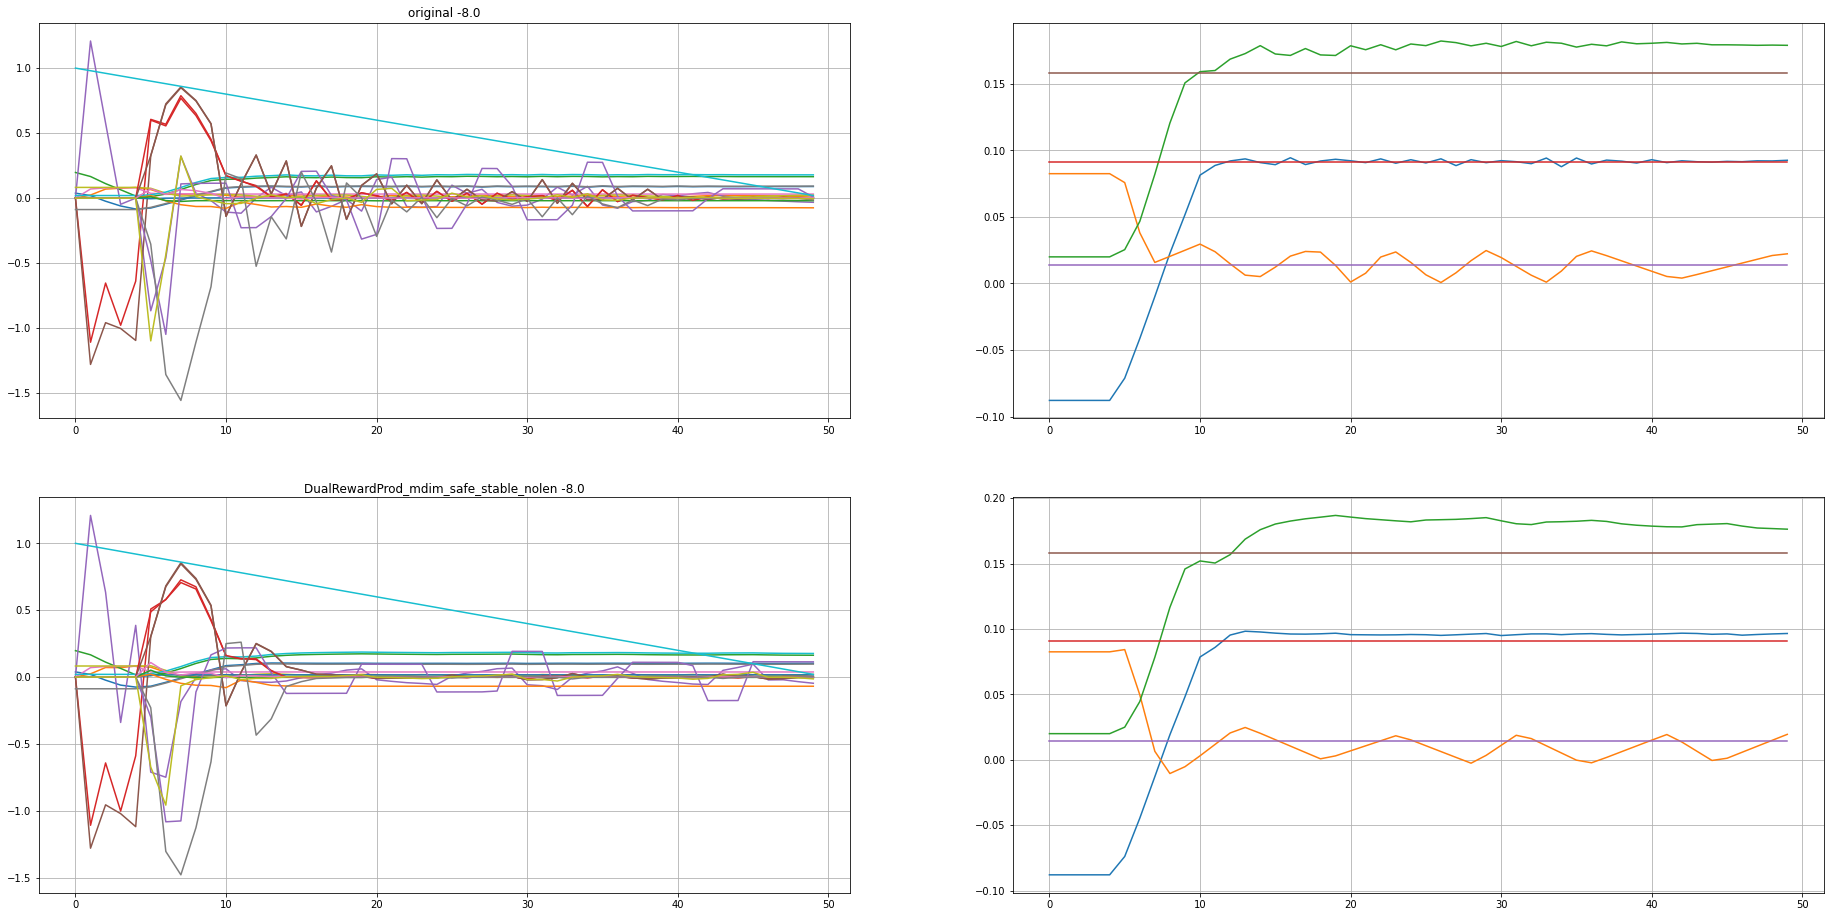

In [158]:
#env_name = 'Walker2DBulletEnv-v0'

env_name = "PandaPickAndPlace-v1"
#env_name = "PandaSlide-v1"
#env_name = "PandaReach-v1"

#env_name = "FetchReach-v1"




post_inv = ['original', 'DualRewardProd_mdim_safe_stable_nolen']
#post_inv = post_list
#post_inv = ['original', 'DualRewardProd_adim_safe_stable_nolen', 'DualRewardDiv_adim_safe_stable_nolen']


figs, axs = plt.subplots(len(post_inv),2, figsize = (32,8*len(post_inv)))

seed = np.random.randint(1,2**32-1)
env = env_dict['tqc'][env_name]

for i, post in enumerate(post_inv):
    model = model_dict['tqc'][env_name][post]
    obs,act,rew,info = do_rollout_mine(env, model, seed=seed)
    obs,ach,des = dict_to_array(obs)
    axs[i,0].title.set_text(post + ' ' + str(np.sum(rew))) 

    axs[i,0].plot(obs)
    axs[i,0].grid()
    
    axs[i,1].plot(ach)
    axs[i,1].plot(des)
    axs[i,1].grid()
    

    
    #axs[i].legend()
    #axs[i].set_label(post)

#from seagul.mesh import dict_to_array

In [137]:
env_name = 'Walker2DBulletEnv-v0'
#figs, axs = plt.subplots(len(post_list), figsize = (8,16))

algo = 'ppo'
env = env_dict[algo][env_name]
counts = [0 for _ in post_list]

for i, post in enumerate(post_list):
    model = model_dict[algo][env_name][post]
    for j in range(100):   
        obs,act,rew,info = do_rollout_mine(env, model)
        #obs,_,_ = dict_to_array(obs)

        if info[0]['episode']['l'] != 1000:
            counts[i] += 1
    
        #axs[i].legend()
        #axs[i].set_label(post)

#from seagul.mesh import dict_to_array

In [136]:
counts

[5, 0]